# Multiple regression analysis in SQL with 3 independent variables
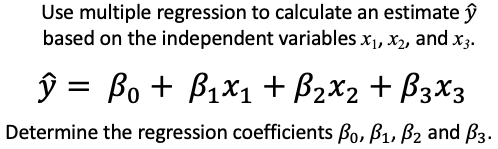

In [ ]:
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame
from data201 import db_connection, df_query

## Read the values

In [ ]:
df = pd.read_csv('ThreeIndependents.csv')
values = list(df.itertuples(index=False, name=None))

df

In [ ]:
conn = db_connection(config_file = 'ThreeIndependents.ini')
cursor = conn.cursor()

In [ ]:
cursor.execute('DROP TABLE IF EXISTS variables')

cursor.execute(
    """
    CREATE TABLE variables
    (
        id INT    NOT NULL,
        x1 DOUBLE NOT NULL,
        x2 DOUBLE NOT NULL,
        x3 DOUBLE NOT NULL,
        y  DOUBLE NOT NULL,
        PRIMARY KEY(id)
    )
    """
)

## Load the `variables` table

In [ ]:
sql = ( """
        INSERT INTO VARIABLES
        VALUES (%s, %s, %s, %s, %s)
        """
      )

cursor.executemany(sql, values)
conn.commit()

In [ ]:
df = df_query(conn, 'SELECT * FROM variables')
df

In [ ]:
X1 = df.x1.to_numpy()
X2 = df.x2.to_numpy()
X3 = df.x3.to_numpy()
Y  = df.y.to_numpy()

## Calculate correlation coefficients with SQL
#### Perform matrix arithmetic.

In [ ]:
ctes = (
    """
    WITH
        base AS (
            SELECT
                x1,
                x1 - AVG(x1) OVER() AS x1_centered,
        
                x2,
                x2 - AVG(x2) OVER() AS x2_centered,
        
                x3,
                x3 - AVG(x3) OVER() AS x3_centered,
        
                y,
                y - AVG(y) OVER()   AS y_centered
            FROM variables
        ),

        regression_1 AS (
            SELECT
                AVG(x1) - AVG(x2) * SUM(x1_centered * x2_centered) 
                    / SUM(x2_centered * x2_centered)                AS x1x2_const,
                SUM(x1_centered * x2_centered) 
                    / SUM(x2_centered * x2_centered)                AS x1x2_coef,
                AVG(x1) - AVG(x3) * SUM(x1_centered * x3_centered) 
                    / SUM(x3_centered * x3_centered)                AS x1x3_const,
                SUM(x1_centered * x3_centered) 
                    / SUM(x3_centered * x3_centered)                AS x1x3_coef,
                AVG(x2) - AVG(x1) * SUM(x2_centered * x1_centered) 
                    / SUM(x1_centered * x1_centered)                AS x2x1_const,
                SUM(x2_centered * x1_centered) 
                    / SUM(x1_centered * x1_centered)                AS x2x1_coef,
                AVG(x2) - AVG(x3) * SUM(x2_centered * x3_centered) 
                    / SUM(x3_centered * x3_centered)                AS x2x3_const,
                SUM(x2_centered * x3_centered) 
                    / SUM(x3_centered * x3_centered)                AS x2x3_coef,
                AVG(x3) - AVG(x1) * SUM(x3_centered * x1_centered) 
                    / SUM(x1_centered * x1_centered)                AS x3x1_const,
                SUM(x3_centered * x1_centered) 
                    / SUM(x1_centered * x1_centered)                AS x3x1_coef,
                AVG(x3) - AVG(x2) * SUM(x3_centered * x2_centered) 
                    / SUM(x2_centered * x2_centered)                AS x3x2_const,
                SUM(x3_centered * x2_centered) 
                    / SUM(x2_centered * x2_centered)                AS x3x2_coef
            FROM base
        ),

        residuals_1 AS (
            SELECT
                y,
                y_centered,
        
                x1,
                x1_centered,
                x2,
                x2_centered,
                x3,
                x3_centered,
        
                x1 - (SELECT x1x2_coef  FROM regression_1) * x2 
                   - (SELECT x1x2_const FROM regression_1)       AS x1x2_resid,
                x1 - (SELECT x1x3_coef  FROM regression_1) * x3 
                   - (SELECT x1x3_const FROM regression_1)       AS x1x3_resid,
                x2 - (SELECT x2x1_coef  FROM regression_1) * x1 
                   - (SELECT x2x1_const FROM regression_1)       AS x2x1_resid,
                x2 - (SELECT x2x3_coef  FROM regression_1) * x3 
                   - (SELECT x2x3_const FROM regression_1)       AS x2x3_resid,
                x3 - (SELECT x3x1_coef  FROM regression_1) * x1 
                   - (SELECT x3x1_const FROM regression_1)       AS x3x1_resid,
                x3 - (SELECT x3x2_coef  FROM regression_1) * x2 
                   - (SELECT x3x2_const FROM regression_1)       AS x3x2_resid
            FROM base
        ),
        
        regression_2 AS (
            SELECT
                SUM(x1_centered * x2x3_resid) 
                    / SUM(x2x3_resid * x2x3_resid)                  AS x1_x2x3_coef,
                SUM(x1_centered * x3x2_resid) 
                    / SUM(x3x2_resid * x3x2_resid)                  AS x1_x3x2_coef,
                AVG(x1) - AVG(x2) * SUM(x1_centered * x2x3_resid) 
                              / SUM(x2x3_resid * x2x3_resid)
                        - AVG(x3) * SUM(x1_centered * x3x2_resid) 
                              / SUM(x3x2_resid * x3x2_resid)        AS x1_const,
                SUM(x2_centered * x1x3_resid) 
                    / SUM(x1x3_resid * x1x3_resid)                  AS x2_x1x3_coef,
                SUM(x2_centered * x3x1_resid) 
                    / SUM(x3x1_resid * x3x1_resid)                  AS x2_x3x1_coef,
                AVG(x2) - AVG(x1) * SUM(x2_centered * x1x3_resid) 
                              / SUM(x1x3_resid * x1x3_resid)
                        - AVG(x3) * SUM(x2_centered * x3x1_resid) 
                              / SUM(x3x1_resid * x3x1_resid)        AS x2_const,
                SUM(x3_centered * x2x1_resid) 
                    / SUM(x2x1_resid * x2x1_resid)                  AS x3_x2x1_coef,
                SUM(x3_centered * x1x2_resid) 
                    / SUM(x1x2_resid * x1x2_resid)                  AS x3_x1x2_coef,
                AVG(x3) - AVG(x1) * SUM(x3_centered * x1x2_resid) 
                              / SUM(x1x2_resid * x1x2_resid)
                        - AVG(x2) * SUM(x3_centered * x2x1_resid) 
                              / SUM(x2x1_resid * x2x1_resid)        AS x3_const
            FROM residuals_1
        ),

        residuals_2 AS (
            SELECT
                y,
                y_centered,
        
                x1,
                x1_centered,
                x2,
                x2_centered,
                x3,
                x3_centered,
        
                x1 - (SELECT x1_x2x3_coef FROM regression_2) * x2
                   - (SELECT x1_x3x2_coef FROM regression_2) * x3
                   - (SELECT x1_const FROM regression_2)           AS x1_resid,
                x2 - (SELECT x2_x1x3_coef FROM regression_2) * x1
                   - (SELECT x2_x3x1_coef FROM regression_2) * x3
                   - (SELECT x2_const FROM regression_2)           AS x2_resid,
                x3 - (SELECT x3_x1x2_coef FROM regression_2) * x1
                   - (SELECT x3_x2x1_coef FROM regression_2) * x2
                   - (SELECT x3_const FROM regression_2)           AS x3_resid
            FROM base
        ),
        
        multiple_regression_3 AS (
            SELECT
                AVG(y) - AVG(x1) * SUM(y_centered * x1_resid) 
                             / SUM(x1_resid * x1_resid)
                       - AVG(x2) * SUM(y_centered * x2_resid) 
                             / SUM(x2_resid * x2_resid)
                       - AVG(x3) * SUM(y_centered * x3_resid) 
                            / SUM(x3_resid * x3_resid)        AS beta0,
                SUM(y_centered * x1_resid) 
                    / SUM(x1_resid * x1_resid)                AS beta1,
                SUM(y_centered * x2_resid) 
                    / SUM(x2_resid * x2_resid)                AS beta2,
                SUM(y_centered * x3_resid) 
                    / SUM(x3_resid * x3_resid)                AS beta3
            FROM residuals_2)
    
    SELECT * FROM multiple_regression_3
    """
)

In [ ]:
df = df_query(conn, ctes)
df

In [ ]:
β0 = df.iloc(0)[0].beta0
β1 = df.iloc(0)[0].beta1
β2 = df.iloc(0)[0].beta2
β3 = df.iloc(0)[0].beta3

In [ ]:
Xs    = np.array([X1, X2, X3]).T
Betas = np.array([β1, β2, β3])

Yhat = []

for x in Xs:
    Yhat.append(x@Betas + β0)

In [ ]:
Errors = Y - Yhat
table = []

for i in range(len(Y)):
    pct = abs(100*Errors[i]/Y[i])
    row = np.concatenate([Xs[i], [Y[i], Yhat[i], Errors[i], pct]])
    
    table.append(row)

In [ ]:
df = DataFrame(table)
df.columns = ['x1', 'x2', 'x3', 'actual y', 
              'est. y', 'error', '% error']

pd.options.display.float_format = '{:,.2f}'.format
display(df)

print(f'correlation coefficient = {np.corrcoef(Y, Yhat)[0, 1]:.2f}')

In [ ]:
cursor.close()
conn.close()